Product Owner have to choose between two KPIs (group of metrics) of his product and invest in one of possible strategies - backlog prioritization. Ads or CRO, attraction or activation or retention. Here I use ML scores of prediction as a measure of KPI selection. I look how KPI/metrics helps to predict possible cash flow. Standard statistical measures like correlation can be enforced by nonlinear ML models. Ensemble voting, binning of target and dimension reduction are involved to avoid overfit. I explore two groups of metrics. First (I) corresponds to conversion - bounce rate, depth of view, micro conversion, time of session, bounce rate. Second (II) corresponds to traffic: number of sessions, new visitors, views. The target function is a number of commercial offers/day. Input features correspond to the New Visitors segment from organic search. 

In [51]:
print('Namaste!')

Namaste!


Import libraries:

In [52]:
import numpy as np 
import pandas as pd 
from pandas import set_option
import matplotlib.pyplot as plt 
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid 
from numpy import linspace, loadtxt, ones, convolve
from statistics import median 
from statistics import mean 
from statistics import stdev 
from math import log
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold 
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from operator import add
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression

Define custom functions:

In [53]:
def standart(x):#normalize to (0,1) interval
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value) / (max_value - min_value)
    return z

def cormap(x):#correlation map
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()
    
def get_class(x):
    class_type=[]
    for item in list(x):
        if 0<=item<0.33:   class_type.append(0) #1 class  
        if 0.33<=item<0.66: class_type.append(1) #2 class
        if 0.66<=item<=1:  class_type.append(4) #3 class
    return class_type

def pca(x,y):#principal components visual output
  pca=PCA()
  pca.fit(y) 
  PCA(copy=True)
  features=x
  pca.explained_variance_=standart(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  print('\nInput of components - PCA:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Read data from three files with crm and web data, parsed through web analytics API.   

In [74]:
df_all=pd.read_excel('all_pages_new.xlsx');df_goal=pd.read_excel('goal_new.xlsx');df_crm=pd.read_excel('crm.xlsx')

df=df_all.merge(df_goal,how='left',left_on='Date',right_on='Date')
del df['Viewers_y'];del df['Views_y'];del df['BR_y'];del df['Depth_y'];del df['Time_y']
df=df.fillna(0)
df['CR,%']=100*df['Visits_y']/df['Visits_x'];del df['Visits_y'] 
df=df.merge(df_crm,how='left',left_on='Date',right_on='Date');df['Offers']=df['Offers'].fillna(0)
df['OFFERS']=df['Offers'];del df['Offers']

In [60]:
column_names=list(df.columns.values)
print('All fields:',column_names)
print('\nData Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])
print('Number of records:', len(df))

All fields: ['Date', 'Visits_x', 'Viewers_x', 'Views_x', 'BR_x', 'Depth_x', 'Time_x', 'CR,%', 'OFFERS']

Data Start: 2016-05-09 00:00:00
Data End: 2019-05-07 00:00:00
Number of records: 1090


Convert features to the (0,1) interval:

In [75]:
date_list=list(df['Date']) 

for item in df.columns.values: 
    df[item]=standart(df[item])   
    
del df['Date']        

Let's find the proportion of days with positive offers number. 

In [62]:
offers_positive=len(df[df['OFFERS']>0])
general_length=len(df)
print('Number of days with [offers>0] number is '+str(round(100*offers_positive/general_length))+'%')

Number of days with [offers>0] number is 70%


Make correlation map and scatter map

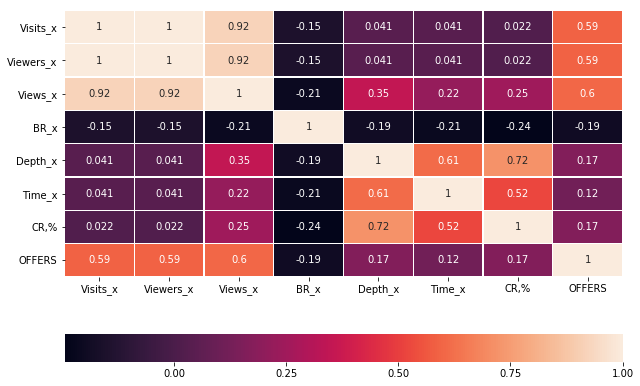

In [63]:
cormap(df)

We can see that Offers are correlated mostly with Visits (sessions)/Viewers/Views - traffic metrics. Small correlation with conversion features. However correlations are non significant in all cases. Let's look at the basic statistical properties. 

In [64]:
description=df['OFFERS'].describe()
print('Common description:\n')
print(description)
print('\nPercentile of 10%:',round(df['OFFERS'].quantile(0.1),2))
print('Percentile of 90%:',round(df['OFFERS'].quantile(0.9),2))

Common description:

count    1090.000000
mean        0.220960
std         0.193596
min         0.000000
25%         0.000000
50%         0.230769
75%         0.346154
max         1.000000
Name: OFFERS, dtype: float64

Percentile of 10%: 0.0
Percentile of 90%: 0.46


We may test classification using binning of (0,1) into the three equal classes.

In [65]:
df_binary_fa=df.copy()
df_binary_fa['Offers_BIN']=get_class(df_binary_fa['OFFERS'])
del df_binary_fa['OFFERS']

If classiicator works well we may predict in what range the target lays. Let's split features and target. Let's make an estimation of feature importance based on tree classifier and Principal Component Analysis. 

In [66]:
model=ExtraTreesClassifier(n_estimators=100)
tree_features=['Visits','Viewers','Views','BR','Depth','Time','Conversion','OFFERS']

array=df_binary_fa.values
X=array[:,0:7];Y=array[:,7]
model.fit(X,Y)
imp=list(model.feature_importances_)
imp=[round(x*100/max(imp)) for x in imp]

print('\nInput of components - Tree:')  
for x,y in zip(tree_features,imp): 
    print(str(x)+':'+str(y)+'%')
    
column_names=df_binary_fa.columns
del df_binary_fa['Offers_BIN']
pca(column_names,df_binary_fa)  


Input of components - Tree:
Visits:89.0%
Viewers:80.0%
Views:100.0%
BR:75.0%
Depth:72.0%
Time:84.0%
Conversion:68.0%

Input of components - PCA:
Visits_x: 100%
Viewers_x: 31%
Views_x: 8%
BR_x: 4%
Depth_x: 2%
Time_x: 0%
CR,%: 0%


According to PCA analysis 'Visits'/'Views' features are the most important. However they are perfectly correlated - we may use one of them to reduce the dimension. This result is validated by the correlation analysis. Now we can move forward to the ensemble of simple classifiers/predictors. First try with all features. We use ensemble of 6 voting estimators. 

In [67]:
split_num=10 #number of splits for cross validation

#define dataframe#
df_binary=df.copy();df_binary['Offers_BIN']=get_class(df_binary['OFFERS']);del df_binary['OFFERS']
array=df_binary.values
X=array[:,0:7];Y=array[:,7]
#/define dataframe#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.8)
#/define split test#

#building the ensemble#
model=KNeighborsClassifier()
n_neighbors=np.arange(5,20,1)
param_grid=dict(n_neighbors=n_neighbors)
grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=split_num,iid=True)
grid.fit(X, Y)

kn=KNeighborsClassifier(n_neighbors=grid.best_estimator_.n_neighbors);gb=GaussianNB()
dt=DecisionTreeClassifier(criterion='entropy');sv=SVC(gamma='auto')
ab=AdaBoostClassifier(n_estimators=100,random_state=7)
gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(3,1), random_state=1, solver='lbfgs')

estimators=[]
estimators.extend([('kn',kn),('naive',gb),('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
ensemble=VotingClassifier(estimators)
#/building the ensemble#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 80/20 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results),1))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 80/20 test=68.0%
Average score:68.5%
Deviation of score:3.8%


Good result. Now we remove all features except number of Sessions.

In [68]:
df_binary=df.copy();df_binary['Offers_BIN']=get_class(df_binary['OFFERS']);del df_binary['OFFERS']

#define dataframe#
del df_binary['Views_x']
del df_binary['Viewers_x']
del df_binary['BR_x']
del df_binary['Time_x']
del df_binary['Depth_x']
del df_binary['CR,%']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:1];Y=array[:,1]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.8)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 80/20 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 80/20 test=67.0%
Average score:72.0%
Deviation of score:4.4%


The result is comparable. Let's look at the cv_number stability.

In [69]:
cv_num=[]
score_cv=[]
S=[]
R=[]
for item in range(3,16):
    
    #building the ensemble#
    model=KNeighborsClassifier()
    n_neighbors=np.arange(5,20,1)
    param_grid=dict(n_neighbors=n_neighbors)
    grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=item,iid=True)
    grid.fit(X, Y)

    kn=KNeighborsClassifier(n_neighbors=grid.best_estimator_.n_neighbors);gb=GaussianNB()
    dt=DecisionTreeClassifier(criterion='entropy');sv=SVC(gamma='auto')
    ab=AdaBoostClassifier(n_estimators=100,random_state=7)
    gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
    mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(3,1), random_state=1, solver='lbfgs')

    estimators=[]
    estimators.extend([('kn',kn),('naive',gb),('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
    ensemble=VotingClassifier(estimators)
    #/building the ensemble#
    
    #output of results#
    cv_scores=list(cross_val_score(ensemble,X,Y,cv=item))
    cv_scores=[round(100*x) for x in cv_scores]
    cv_num.append(item)#split number
    score_cv.append(mean(cv_scores)) #score
    R.append(max(cv_scores)-min(cv_scores))#R
    S.append(stdev(cv_scores)) #S
    print('Number of cv: '+str(item)+' Average score: '+str(round(mean(cv_scores)))+'%')
    #/output of results#

Number of cv: 3 Average score: 69.0%
Number of cv: 4 Average score: 72.0%
Number of cv: 5 Average score: 71.0%
Number of cv: 6 Average score: 71.0%
Number of cv: 7 Average score: 70.0%
Number of cv: 8 Average score: 71.0%
Number of cv: 9 Average score: 71.0%
Number of cv: 10 Average score: 72.0%
Number of cv: 11 Average score: 70.0%
Number of cv: 12 Average score: 72.0%
Number of cv: 13 Average score: 71.0%
Number of cv: 14 Average score: 71.0%
Number of cv: 15 Average score: 72.0%


Quite stable in relation to the scale. PO may focus on traffic attraction as this metric has the same predictive power as the initial set. Let's insert moving averages with for sessions,BR and offers to verify the result. Let's look at the moving averages with 1Q window.

In [76]:
Sessions=list(df['Visits_x'])
Offers=list(df['OFFERS'])
BR=list(df['BR_x'])
CR=list(df['CR,%'])

ma_window=60

#x=range(len(Sessions))
x=date_list
y_av_ses=list(movingaverage(Sessions,ma_window))
y_av_offers=list(movingaverage(Offers,ma_window))
y_av_br=list(movingaverage(BR,ma_window))
y_av_cr=list(movingaverage(CR,ma_window))
y_av_kpi=[(x-y) for x,y in zip(y_av_ses,y_av_offers)]

df_ma={'Sessions':y_av_ses,'Offers':y_av_offers,'Bounce rate':y_av_br,'Conversion rate':y_av_cr,'Gap':y_av_kpi}
df_ma=pd.DataFrame(df_ma)
print(df_ma.corr())

                 Sessions    Offers  Bounce rate  Conversion rate       Gap
Sessions         1.000000  0.643882     0.083632        -0.723152  0.971984
Offers           0.643882  1.000000     0.185981        -0.214067  0.446002
Bounce rate      0.083632  0.185981     1.000000         0.203222  0.040698
Conversion rate -0.723152 -0.214067     0.203222         1.000000 -0.780171
Gap              0.971984  0.446002     0.040698        -0.780171  1.000000


It is worth to note tha Conversion rate is anti-correlated with Traffic Volume. 

<Figure size 432x288 with 0 Axes>

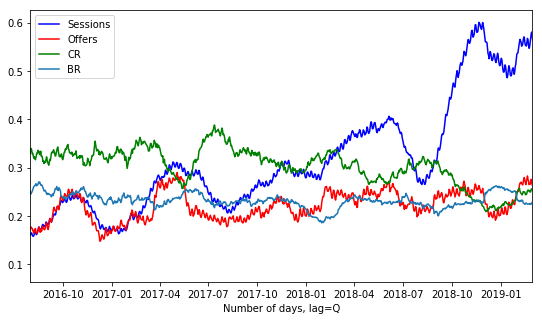

<Figure size 432x288 with 0 Axes>

In [91]:
plt.figure(figsize=(9,5))
plt.plot(x, y_av_ses,'b')
plt.plot(x, y_av_offers,'r')
plt.plot(x,y_av_cr,'g')
plt.plot(x,y_av_br)

plt.xlabel('Number of days, lag=Q')
plt.xlim(left='2016-08',right='2019-03')
plt.gca().legend(('Sessions','Offers','CR','BR'))
plt.figure()


<Figure size 432x288 with 0 Axes>

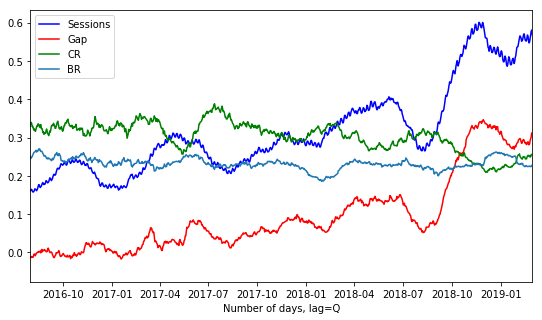

<Figure size 432x288 with 0 Axes>

In [96]:
plt.figure(figsize=(9,5))
plt.plot(x, y_av_ses,'b')
plt.plot(x, y_av_kpi,'r')
plt.plot(x,y_av_cr,'g')
plt.plot(x,y_av_br)

plt.xlabel('Number of days, lag=Q')
plt.xlim(left='2016-08',right='2019-03')
plt.gca().legend(('Sessions','Gap','CR','BR'))
plt.figure()

These charts give a visual interpretation of traffic KPI importance. However the gap between Offers and Sessions is growing - almost 90% of correlation with traffic. It gives and idea that traffic 'quantity' increase is reached by its quality. In this research I have shown an example of strategy uncertainty when ML gives significant validation in addition to standard statistical instruments.